<a href="https://colab.research.google.com/github/milqsimmer/IA905a/blob/main/Demo_261300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nome: Camila Maria Serra Quadros

RA: 261300

Curso: Mestrado (aluna especial) - Graduada em Engenharia Mecatrônica



# Contando moedas em uma imagem

A partir de imagens com moedas, iremos utilizar o processamento de imagens para identificar o valor de cada moeda e contar a soma final.

In [2]:
# Importando as bibliotecas que serão utilizadas
from PIL import Image
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

# Definindo o nome da pasta compartilhada
pasta_compartilhada = "P_IA905A_2024S1"

In [3]:
# Conexão do colab com o drive
from google.colab import drive
drive.mount('/content/gdrive')
path = f"gdrive/MyDrive/{pasta_compartilhada}/Dados/Ex03/"

Mounted at /content/gdrive


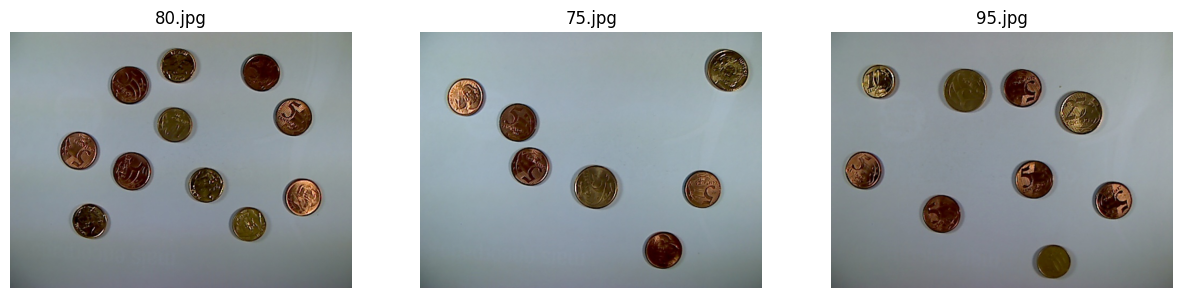

In [5]:
# Printando as 3 imagens dadas

fig, axs = plt.subplots(1,3,figsize=(15, 6))

path_moedas = path+'Moedas/'

list_files = os.listdir(path_moedas)
for i, file in enumerate(list_files):
  plt.subplot(1,3,1+i)
  plt.axis('off')
  plt.title(file)
  img = mpimg.imread(path_moedas+file)
  plt.imshow(img)

## Segmentação

Foi criada a função "seg_and_postprocessing" que irá isolar o formato de cada moeda nas imagens. A função recebe uma imagem e 2 números que irão ser utilizados para o kernel (mais informações a seguir).



1.   Primeiro separamos o fundo da imagem das moedas. Foi utilizada a biblioteca OpenCV. A função threshold utiliza como parâmetros a imagem em cinza com limites de 0 a 255 e para definição do threshold uma combinação de Binary com OTSU. Para mais informações, veja https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html.



```
def seg_and_postprocessing(img, k_cl, k_op):
    binr = cv2.threshold(255 - img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1] # usa opencv pra fazer o corte nas imagens com os limites binário e de otsu
```

2.   Transformação morfológica: criamos dois kernels para remoção de ruídos, primeiro foi aplicado o Closing e depois o Opening. Para mais informações, veja https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html



```
def seg_and_postprocessing(img, k_cl, k_op):
    binr = cv2.threshold(255 - img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    kernel_cl = np.ones((k_cl, k_cl), np.uint8)
    kernel_op = np.ones((k_op, k_op), np.uint8)

    close = cv2.morphologyEx(binr, cv2.MORPH_CLOSE, kernel_cl, iterations=1) # https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
    open = cv2.morphologyEx(close, cv2.MORPH_OPEN, kernel_op, iterations=1)
```


3.  Plotando as imagens em cinza, com Closing aplicado e com Opening aplicado, respectivamente:



```
def seg_and_postprocessing(img, k_cl, k_op):
    binr = cv2.threshold(255 - img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    kernel_cl = np.ones((k_cl, k_cl), np.uint8)
    kernel_op = np.ones((k_op, k_op), np.uint8)

    close = cv2.morphologyEx(binr, cv2.MORPH_CLOSE, kernel_cl, iterations=1)
    open = cv2.morphologyEx(close, cv2.MORPH_OPEN, kernel_op, iterations=1)

    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.imshow(binr, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(close, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(open, cmap='gray')
    plt.axis('off')
    plt.show()
```

4.  A função retorna a imagem após esses processos.



In [6]:
import cv2

def seg_and_postprocessing(img, k_cl, k_op):
    binr = cv2.threshold(255 - img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    kernel_cl = np.ones((k_cl, k_cl), np.uint8)
    kernel_op = np.ones((k_op, k_op), np.uint8)

    close = cv2.morphologyEx(binr, cv2.MORPH_CLOSE, kernel_cl, iterations=1)
    open = cv2.morphologyEx(close, cv2.MORPH_OPEN, kernel_op, iterations=1)

    plt.figure(figsize=(12,6))
    plt.subplot(1,3,1)
    plt.imshow(binr, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(close, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(open, cmap='gray')
    plt.axis('off')
    plt.show()

    return open

## Classificando as moedas por tamanho

Foi criada a função "calc_npixels_label" para contar os pixels de cada moeda após a segmentação.



```
def calc_npixels_label(img, n_labels): #calculando qtd de pixels em cada novo formato na imagem
    list_npixels = []
    for v in range(n_labels-1):
        npixels = (img[img == v+1]//(v+1)).sum()
        list_npixels.append(npixels)
    return list_npixels
```



In [43]:
def calc_npixels_label(img, n_labels): #calculando qtd de pixels em cada novo formato na imagem
    list_npixels = []
    for v in range(n_labels-1):
        npixels = (img[img == v+1]//(v+1)).sum()
        list_npixels.append(npixels)
    return list_npixels

## Fazendo a contagem

1.  Convertendo as imagens para escala de cinza: Para converter a imagem foi utilizada a fórmula NTSC que usa uma combinação de 30%, 59% e 11% de vermelho, verde e azul, respectivamente. É feito um merging das 3 bandas com essas porcentagens para formar a imagem em cinza.


```
img_gray = np.uint8(0.3*img[:,:,0]+0.59*img[:,:,1]+0.11*img[:,:,2])
```

2.  Chamo a função "seg_and_postprocessing" com a imagem em cinza e valores de 15 e 31 para os kernels de Closing e Opening.


```
seg_img = seg_and_postprocessing(img_gray, 15, 31)
```

3.  Pegando os status de cada forma: utilizando a função "connectedComponentsWithStats" da biblioteca OpenCV, separamos cada formato diferente em cores diferentes e plotamos. Para mais informações, veja https://docs.opencv.org/4.7.0/d3/dc0/group__imgproc__shape.html#gae57b028a2b2ca327227c2399a9d53241.



```
output = cv2.connectedComponentsWithStats(seg_img, 4)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(output[1])
plt.axis('off')
```

4.  Calculando quantidade de pixels por forma: chamando a função "calc_npixels_label".


```
list_npixels = calc_npixels_label(output[1], output[0])
```

5.  Soma final dos valores: definindo limites de pixel para moedas de 5, 10 e 25, somamos os valores de cada moeda:



```
  soma = 0
  for n, p in enumerate(list_npixels):
    x = int(output[3][n+1][0])
    y = int(output[3][n+1][1])

    if p < 3500: # menos pixels que 3500 são 10 centavos
      soma += 10
      cv2.putText(img, '10', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    elif p > 4600: # mais pixels que 4600 são 25 centavos
      soma += 25
      cv2.putText(img, '25', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    else:
      soma += 5 # outro tamanho são 5 centavos
      cv2.putText(img, '5', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
```






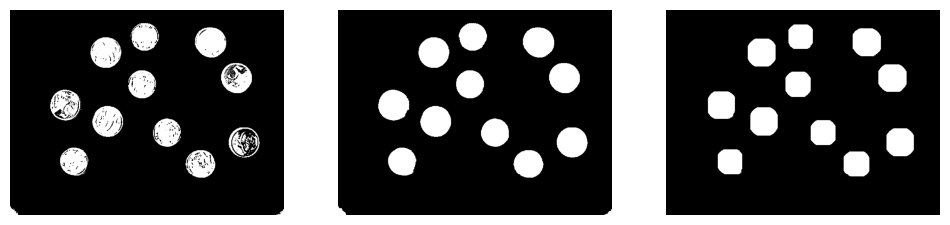

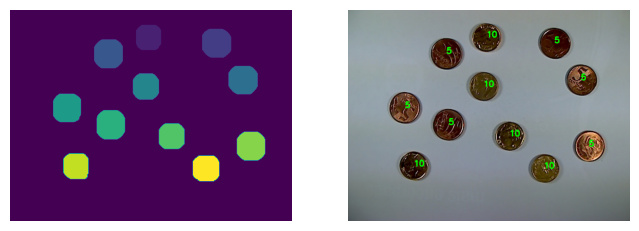

Imagem 80.jpg
Número de moedas 11
[2978, 3793, 3775, 3736, 3132, 3678, 3778, 3064, 3728, 3049, 3183]
Valor total: 80



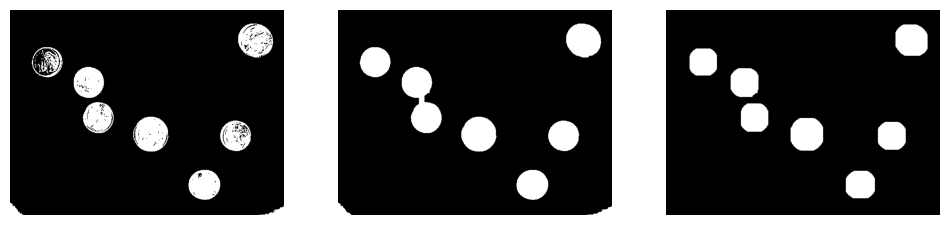

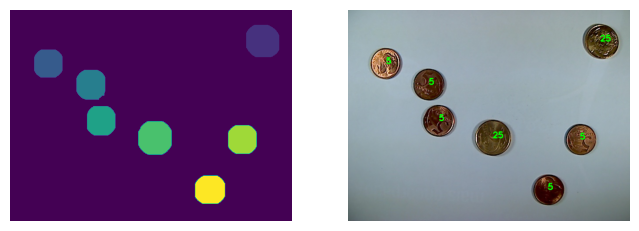

Imagem 75.jpg
Número de moedas 7
[4805, 3638, 3867, 3786, 5016, 3767, 3861]
Valor total: 75



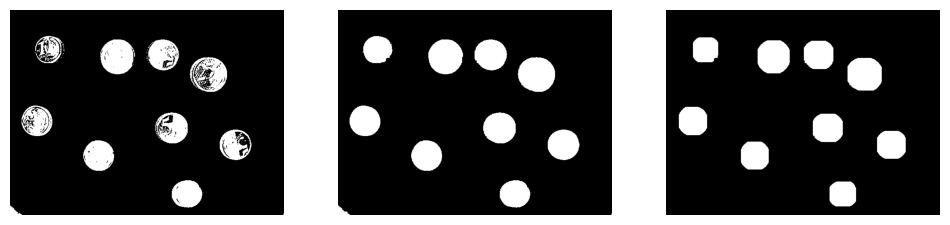

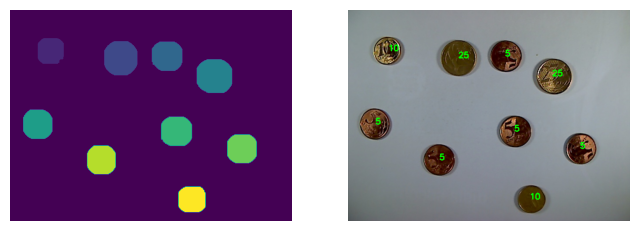

Imagem 95.jpg
Número de moedas 9
[3114, 4997, 4017, 5335, 3845, 4113, 3897, 3766, 3285]
Valor total: 95



In [39]:
for i, file in enumerate(list_files):
  img = mpimg.imread(path_moedas+file).astype('uint8')
  img_gray = np.uint8(0.3*img[:,:,0]+0.59*img[:,:,1]+0.11*img[:,:,2])

  seg_img = seg_and_postprocessing(img_gray, 15, 31)
  output = cv2.connectedComponentsWithStats(seg_img, 4) # https://docs.opencv.org/4.7.0/d3/dc0/group__imgproc__shape.html#gae57b028a2b2ca327227c2399a9d53241

  plt.figure(figsize=(8,4))
  plt.subplot(1,2,1)
  plt.imshow(output[1])
  plt.axis('off')

  list_npixels = calc_npixels_label(output[1], output[0])

  soma = 0
  for n, p in enumerate(list_npixels):
    x = int(output[3][n+1][0])
    y = int(output[3][n+1][1])

    if p < 3500: # menos pixels que 3500 são 10 centavos
      soma += 10
      cv2.putText(img, '10', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    elif p > 4600: # mais pixels que 4600 são 25 centavos
      soma += 25
      cv2.putText(img, '25', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    else:
      soma += 5 # outro tamanho são 5 centavos
      cv2.putText(img, '5', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  print('Imagem', file)
  print('Número de moedas', len(list_npixels))
  print(list_npixels)
  print('Valor total:', soma)
  print()